<a href="https://colab.research.google.com/github/shayan823/reward_related_society/blob/main/better_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from itertools import groupby
!pip install --quiet nma-ibl

import datajoint as dj

dj.config["database.host"] = "datajoint-public.internationalbrainlab.org"
dj.config["database.user"] = "ibl-public"
dj.config["database.password"] = "ibl-public" 
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses

[2022-07-28 19:18:55,118][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2022-07-28 19:18:57,457][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')

In [66]:
def get_plots_for_acc_vs_learning(pc, train, test, roc_list, method):
    data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                        "train_accuracy": train,
                                        "test_accuracy": test,
                                        "roc-auc": roc_list}
                                        
    df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")

    plt.figure(figsize=(9,6))
    ax = sns.lineplot(data=df)
    ax.set_ylabel("Metrics")
    plt.savefig("./plots/acc_vs_percentage_{}.png".format(method))
    plt.show()

In [3]:
def length_last_streak(all_trials,current_trial,streak_type=1):
    """ Gives length of streak of streak_type preceding the current_trial
    Args:
        all_trials (numpy array): an array with all feddback for the session (+1/-1)
        current_trial (int): the index of the current trial
        streak_type (int, optional): type of streak to search for. Defaults to 1, aka reward, else -1 for failure

    Returns:
        len_last_streak:  length of streak of streak_type preceding the current_trial. None if not current type or streak length <2
    """
    #len_last_streak = None as a feature you shouldnt have none
    len_last_streak = 0
    if current_trial > 0:
        grouped_before_index = [list(g) for k,g in groupby(all_trials[:current_trial])] #index is excluded
        if grouped_before_index[-1][0] == streak_type:
        
            if len(grouped_before_index[-1]) > 1:
                len_last_streak = len(grouped_before_index[-1])
    
    return len_last_streak
def fetch_mice_by_percentage(lab_mice, lab_mice_in_training, percentage):
  dictionary = {}

  for mouse in lab_mice:
    one_guy = lab_mice_in_training & {'subject_uuid' : mouse}
    total_trials = len(one_guy.fetch('training_status'))
    train_percentage = np.arange(1,total_trials+1) / total_trials

    bins = np.linspace(0, 100, 10)
    train_percentage_bin = np.digitize(train_percentage*100, bins)*10
    where = np.where(train_percentage_bin == percentage)[0]
    if len(where) !=0:
      dictionary[mouse] = one_guy.fetch('session_start_time')[where]
  return dictionary

def search_sequence(arr,streak_length, feedback):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    streak_length    : input int

    Output
    ------    
    Output : 1D Array with 1s on indices where input array matches the sequence and 0s otherwise.
    """
    # Create the sequence to look for
    seq = np.ones(streak_length)*feedback

    # Store sizes of input array and sequence
    streak = np.zeros(arr.size)
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq)[:,None] + r_seq] == seq).all(1)

    # Get True values of M and write streak array
    where = np.where(M == True)[0] 
    streak[where] = 1

    return streak

def get_streak_data(lab,percentage,features):
  """ Returns streak of rewards and/or punishments before all trials with 50/50 probability, for all mice in chosen lab, with chosen training percentage.

  Parameters
  ----------    
  lab    : input string
  percentage    : input int
  features: input list of signed ints (positive for reward streak length, negative for punish streak length)

  Output
  ------    
  Output :
  2D array with size (features x samples)
  1D array with size samples
  """


  lab_mice_in_training = ((behavior_analyses.SessionTrainingStatus & {'training_status' : 'in_training'}) * subject.SubjectLab & {'lab_name' : lab}) & behavior.TrialSet.Trial
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)


  X = np.empty((len(features)+1,1))
  
  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
        x_0 = contrast_left + contrast_right
        x = x_0

        for feature in features:
          x = np.vstack( (x,search_sequence(session,abs(feature), np.sign(feature) )))
        
        X = np.concatenate((X,x),axis=1)


        y = np.append(y,session)
    except:
      pass
    
  return(X[:,1:],y.astype('int'))

In [24]:
def get_complete_data(lab, percentage,status): 
  #status should be either ['trained'] or ['trained_1a','trained_1b']
  lab_mice_in_training = behavior_analyses.SessionTrainingStatus & [{'training_status': t} for t in status]  & (subject.SubjectLab & 'lab_name = "{}"'.format(lab)) 
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)
  # print(dictionary)

  X_0=[]
  X_1=[]
  X_2=[]
  X_rew = []
  X_Left_loc = []
  X_Right_loc = []
  X_rt = []

  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right, volume, time_onset, time_response = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type',
        'trial_stim_contrast_left',
        'trial_stim_contrast_right',
        'trial_reward_volume',
        'trial_stim_on_time',
        'trial_response_time')

        is_nan = np.argwhere(np.isnan(volume))[:,0]
        if len(is_nan) == len(session) : # all the session is to throw away
          continue 
              
        if len(is_nan) != len(session) and len(is_nan) != 0:
          raise Exception("Sorry, I dont know how to deal with missing water reward information in few trials only")
        
        
        x_0 = contrast_left + contrast_right

        reaction_time = [r-o for (r,o) in zip(time_response, time_onset)]
        location_left = [1  if el != 0 else -1 for el in contrast_left]
        
        streak_location_left = [length_last_streak(location_left,j,1) for j in range(len(location_left))]
        streak_location_right = [length_last_streak(location_left,j,-1) for j in range(len(location_left))]

        x_pos = [length_last_streak(session,j,1) for j in range(len(session))]
        x_neg = [length_last_streak(session,j,-1) for j in range(len(session))]
        x_rew = np.cumsum(volume)
        x_left_loc = streak_location_left
        x_right_loc = streak_location_right
        x_reaction_time = reaction_time

        X_0 = np.append(X_0,x_0)
        X_1 = np.append(X_1,x_pos)
        X_2 = np.append(X_2,x_neg)
        X_rew = np.append(X_rew,x_rew)
        X_Left_loc = np.append(X_Left_loc,x_left_loc)
        X_Right_loc = np.append(X_Right_loc,x_right_loc)
        # X_rt = np.append(X_rt, x_reaction_time)

        y = np.append(y,session)
    except:
      pass
  X = np.vstack((X_0,X_1,X_2, X_rew, X_Left_loc,X_Right_loc))
  X = X.astype("float")
  y = y.astype("float")

  return (X, y)

In [5]:
def streak_modelling(X,y):
    #  Splitting the dataset into train and test set
    x_train, x_test, y_train, y_test = train_test_split(X.T, y, test_size=0.25, random_state=0)

    # Normalizing the features before passing it to the model
    scaler = StandardScaler().fit(x_train)
    x_norm_train = scaler.transform(x_train)
    x_norm_test = scaler.transform(x_test)

    logisticRegr = LogisticRegression(class_weight='balanced')
    logisticRegr.fit(x_norm_train, y_train)
    coef = logisticRegr.coef_[0]

    y_pred = logisticRegr.predict(x_norm_test)

    #   Calculating accuracy of the model
    training_accuracy = logisticRegr.score(x_norm_train, y_train)
    test_accuracy = logisticRegr.score(x_norm_test, y_test)
    print("Training accuracy:{:.2f}  Test accuracy:{:.2f}".format(training_accuracy*100, test_accuracy*100))
    # print("Precision:{:.2f} Recall:{:.2f}".format(precision_score(y_pred, y_test)*100,
    #                                             recall_score(y_pred, y_test)*100))

    #   Calculating roc-auc of the model
    roc = roc_auc_score(y_test, y_pred)
    print("roc-auc score:{:.2f}".format(roc))
    print("Coefficients for logistic regression:")
    print(coef)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("TN:{} FP:{} FN:{} TP:{}".format(tn, fp, fn, tp))
    return training_accuracy, test_accuracy, coef, roc

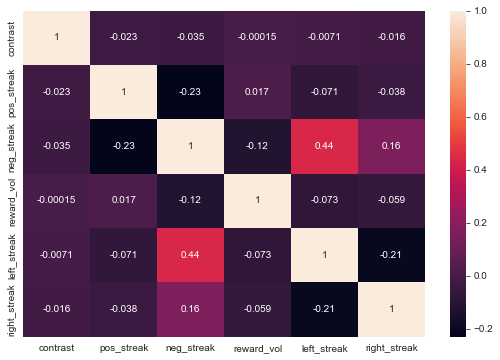

In [49]:
X, y = get_complete_data("mainenlab", 10, ['in_training'])

column_names = ["contrast", "pos_streak", "neg_streak", "reward_vol", "left_streak", "right_streak"]
df_corr=pd.DataFrame(data=X.T, columns=column_names)
corr = df_corr.corr()

plt.figure(figsize=(9,6))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)
plt.show()

In [41]:
train_acc, test_acc, coef, roc = streak_modelling(X,y)

Training accuracy:61.11  Test accuracy:61.36
roc-auc score:0.61
Coefficients for logistic regression:
[ 0.13262772  0.1272947  -0.57308718  0.13479218  0.07487823  0.03481268]
TN:104 FP:108 FN:57 TP:158


In [64]:
pc=np.arange(10,100,10)
train=[]
test=[]
coef_contrast=[]
coef_pos_streak=[]
coef_neg_streak=[]
coef_rew_vol = []
coef_streak_left = []
coef_streak_right = [] 
roc_list=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_complete_data("mainenlab", percentage, ['in_training'])
    train_acc, test_acc, coef, roc = streak_modelling(data_X, data_y)

    train.append(train_acc)
    test.append(test_acc)

    coef_contrast.append(coef[0])
    coef_pos_streak.append(coef[1])
    coef_neg_streak.append(coef[2])
    coef_rew_vol.append(coef[3])
    coef_streak_left.append(coef[4])
    coef_streak_right.append(coef[5])
    roc_list.append(roc)
    print("----")

%_trained_mice_considered:10
Training accuracy:53.28  Test accuracy:54.06
roc-auc score:0.55
Coefficients for logistic regression:
[-0.00535314 -0.04249806 -0.08738761  0.06117835 -0.16382225 -0.11050827]
TN:246 FP:306 FN:175 TP:320
----
%_trained_mice_considered:20
Training accuracy:54.44  Test accuracy:53.87
roc-auc score:0.55
Coefficients for logistic regression:
[ 0.0050546   0.07811819 -0.23081827  0.09242901  0.00212747 -0.01952886]
TN:465 FP:524 FN:317 TP:517
----
%_trained_mice_considered:30
Training accuracy:57.72  Test accuracy:56.94
roc-auc score:0.58
Coefficients for logistic regression:
[ 0.05447565  0.10726468 -0.22997528  0.34148205 -0.06412348  0.02285102]
TN:670 FP:390 FN:705 TP:778
----
%_trained_mice_considered:40
Training accuracy:58.66  Test accuracy:56.83
roc-auc score:0.57
Coefficients for logistic regression:
[ 0.13686385  0.18299909 -0.19190946  0.29561587 -0.03843068 -0.04091847]
TN:816 FP:569 FN:1271 TP:1606
----
%_trained_mice_considered:50
Training accuracy

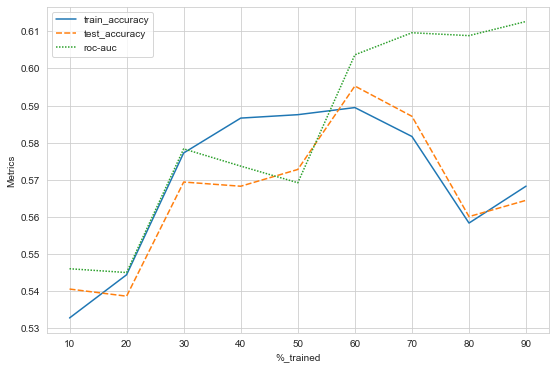

In [67]:
get_plots_for_acc_vs_learning(pc, train, test, roc_list, 'method-2_added_feat')

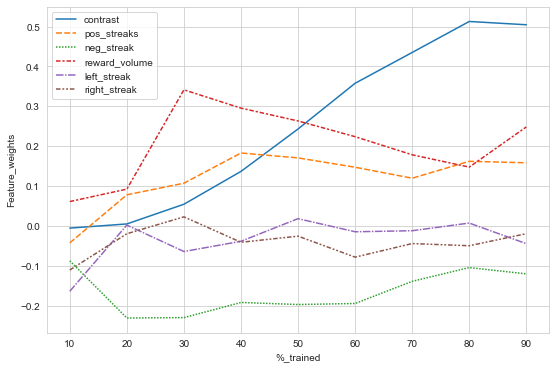

In [68]:
data_for_wts_vs_percentage_trained = {"%_trained":pc,
                                      "contrast": coef_contrast,
                                      "pos_streaks": coef_pos_streak,
                                      "neg_streak": coef_neg_streak,
                                      "reward_volume": coef_rew_vol,
                                      "left_streak": coef_streak_left,
                                      "right_streak": coef_streak_right}
                                      
df1 = pd.DataFrame(data_for_wts_vs_percentage_trained).set_index("%_trained")

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=df1)
ax.set_ylabel("Feature_weights")
# plt.savefig("./plots/weights_vs_percentage_method-2_added_feat.png")
plt.show()